In [1]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader

### Read Dataset

In [2]:
data = pd.read_csv('/kaggle/input/aiomodule6weather-forecast/dataset/weatherHistory.csv')
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [3]:
data_final = data.select_dtypes(float)
data_final = data_final.drop(columns = ['Apparent Temperature (C)'])
data_final.head()

,Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars)
0,9.472222,0.89,14.1197,251.0,15.8263,0.0,1015.13
1,9.355556,0.86,14.2646,259.0,15.8263,0.0,1015.63
2,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94
3,8.288889,0.83,14.1036,269.0,15.8263,0.0,1016.41
4,8.755556,0.83,11.0446,259.0,15.8263,0.0,1016.51


In [4]:
data_final.values[:5]

array([[9.47222222e+00, 8.90000000e-01, 1.41197000e+01, 2.51000000e+02,
        1.58263000e+01, 0.00000000e+00, 1.01513000e+03],
       [9.35555556e+00, 8.60000000e-01, 1.42646000e+01, 2.59000000e+02,
        1.58263000e+01, 0.00000000e+00, 1.01563000e+03],
       [9.37777778e+00, 8.90000000e-01, 3.92840000e+00, 2.04000000e+02,
        1.49569000e+01, 0.00000000e+00, 1.01594000e+03],
       [8.28888889e+00, 8.30000000e-01, 1.41036000e+01, 2.69000000e+02,
        1.58263000e+01, 0.00000000e+00, 1.01641000e+03],
       [8.75555556e+00, 8.30000000e-01, 1.10446000e+01, 2.59000000e+02,
        1.58263000e+01, 0.00000000e+00, 1.01651000e+03]])

### Create Sequence From Dataset

In [5]:
def create_sequences(df, lag, ahead):
    features = []
    labels = []

    for i in range(len(df) -lag -ahead +1):
        feature = df.values[i:(i+lag)]
        label = df["Temperature (C)"].values[(i+lag):(i+lag+ahead)]

        features.append(feature)
        labels.append(label)

    return np.array(features), np.array(labels).squeeze()

X, y = create_sequences(data_final, 6, 1)
X.shape, y.shape

((96447, 6, 7), (96447,))

### Split dataset

In [6]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

features = X.tolist()
targets = y.tolist()

X_train, X_val, y_train, y_val = train_test_split(
    features, targets,
    test_size=val_size,
    random_state=seed,
    shuffle=is_shuffle
)

X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train,
    test_size=test_size,
    random_state=seed,
    shuffle=is_shuffle
)

### Pytorch Dataset

In [16]:
import torch
from torch.utils.data import Dataset

class WeatherForecast(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]

        return torch.tensor(features, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32)

In [17]:
train_dataset = WeatherForecast(
    X_train, 
    y_train,
)

val_dataset = WeatherForecast(
    X_val, 
    y_val,
)

test_dataset = WeatherForecast(
    X_test, 
    y_test,
)

In [18]:
sample_id = 2

# Check 0-th sample and dataset length
text0, label0 = train_dataset[sample_id]
print(f"Train 0-th sample - text shape: {text0.shape}, label: {label0}")
print(f"Train dataset length: {len(train_dataset)}")

text0_val, label0_val = val_dataset[sample_id]
print(f"Val 0-th sample - text shape: {text0_val.shape}, label: {label0_val}")
print(f"Val dataset length: {len(val_dataset)}")

text0_test, label0_test = test_dataset[sample_id]
print(f"Test 0-th sample - text shape: {text0_test.shape}, label: {label0_test}")
print(f"Test dataset length: {len(test_dataset)}")


Train 0-th sample - text shape: torch.Size([6, 7]), label: 9.872221946716309
Train dataset length: 67512
Val 0-th sample - text shape: torch.Size([6, 7]), label: 2.172222137451172
Val dataset length: 19290
Test 0-th sample - text shape: torch.Size([6, 7]), label: 5.205555438995361
Test dataset length: 9645


### Data Loader

In [19]:
test_batch_size = 64
train_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

### Build RNN Model

In [26]:
class TemperatureForecast(nn.Module):
    def __init__(
        self, rnn_cell,
        hidden_size, n_layers,
        dropout_prob, use_global_pooling = False
    ):
        super().__init__()

        self.use_global_pooling = use_global_pooling
        self.rnn_cell = rnn_cell

        self.averagepool = nn.AdaptiveAvgPool1d(1)
        
        if self.rnn_cell == "RNN":
            self.cell = nn.RNN(
                7,
                hidden_size,
                n_layers,
                batch_first=True
            )
        elif self.rnn_cell == "LSTM":
            self.cell = nn.LSTM(
                7,
                hidden_size,
                n_layers,
                batch_first=True
            )
        else:
            self.cell = nn.GRU(
                7,
                hidden_size,
                n_layers,
                batch_first=True
            )
               
        self.norm = nn.LayerNorm(hidden_size)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, 1)

    def forward(self, x):
        
        if self.rnn_cell in ["RNN", "GRU"]:
            x, hn = self.cell(x)
        else:
            x, (hn, cn) = self.cell(x)
            
        if not self.use_global_pooling:  
            x = x[:, -1, :]
            x = self.norm(x)
            x = self.dropout(x)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)
        else:
            x = x[:, :, :] # (B, L, D)
            x = self.norm(x)
            x = self.dropout(x)
            x = x.transpose(1, 2) # (B, D, L)
            x = self.averagepool(x) # (B, D, 1)
            x = x.squeeze(-1) # (B, D)
            x = self.fc1(x)
            x = self.relu(x)
            x = self.fc2(x)

        return x

In [31]:
hidden_size = 64
n_layers = 3
dropout_prob = 0.2
use_global_pooling = False
rnn_cell = "LSTM"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TemperatureForecast(
    hidden_size=hidden_size,
    rnn_cell = rnn_cell,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    use_global_pooling = use_global_pooling
).to(device)

In [35]:
from torchinfo import summary
summary(model, input_size=(10, 6, 7))  # seq_len=10, batch_size=6, input_size=7

Layer (type:depth-idx)                   Output Shape              Param #
TemperatureForecast                      [10, 1]                   --
├─LSTM: 1-1                              [10, 6, 64]               85,248
├─LayerNorm: 1-2                         [10, 64]                  128
├─Dropout: 1-3                           [10, 64]                  --
├─Linear: 1-4                            [10, 16]                  1,040
├─ReLU: 1-5                              [10, 16]                  --
├─Linear: 1-6                            [10, 1]                   17
Total params: 86,433
Trainable params: 86,433
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 5.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.35
Estimated Total Size (MB): 0.38

In [40]:
from typing import Literal, Optional
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from sklearn.metrics import f1_score, r2_score, accuracy_score
class training_model:
    def __init__(self, model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler: callable = None, metrics: dict[str, callable] = {"Accuracy": (accuracy_score, {})}, refit: str = "Accuracy"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = metrics
        self.refit = refit
        self.best_model_state = None
        self.scheduler = scheduler

    # Define train function
    def train_session(self):
        train_loss = 0
        total_samples = 0
        
        y_train_label_pred = []
        y_train_label_true = []

        metric_dict_train = {}

        # training session
        self.model.train()
        for X_train, y_train in self.train_loader:
            # X_train: (batch_size, in_channels, height, width)
            # y_train: (batch_size)

            y_train = y_train.to(device)
            X_train = X_train.to(device)
            
            self.optimizer.zero_grad() # reset optimizer gradients

            # forward pass
            output = self.model(X_train).squeeze() # output: (batch_size, num_classes)

            # calculate loss
            loss = self.criterion(output, y_train)
            train_loss += loss.item() * len(y_train)
            total_samples += len(y_train)

            # Predictions
            y_train_label_true.extend(y_train.tolist())
            y_train_label_pred.extend(output.tolist())

            # calculate gradients
            loss.backward()

            # update weights
            self.optimizer.step()
        
        train_loss /= total_samples

        for metric_name, (metric_func, kwargs) in self.metrics.items():
            metric = metric_func(y_train_label_true, y_train_label_pred, **kwargs)
            metric_dict_train[metric_name] = metric

        return train_loss, metric_dict_train
    
    # Define validation (testing) function
    def eval_session(self, mode: Literal['Eval', 'Test'] = 'Eval'):
        # validation session
        self.model.eval()
        with torch.no_grad():
            if mode == "Eval":
                val_loss = 0
                total_samples = 0

                y_val_label_pred = []
                y_val_label_true = []

                metric_dict_val = {}
                for X_val, y_val in self.val_loader:
                    # X_val: (batch_size, in_channels, height, width)
                    # y_val: (batch_size)
    
                    y_val = y_val.to(device)
                    X_val = X_val.to(device)
                    
                    # forward pass
                    output = self.model(X_val).squeeze() # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_val)
                    val_loss += loss.item() * len(y_val)
                    total_samples += len(y_val)
    
                    # Predictions
                    y_val_label_true.extend(y_val.tolist())
                    y_val_label_pred.extend(output.tolist())
            
                val_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_val_label_true, y_val_label_pred, **kwargs)
                    metric_dict_val[metric_name] = metric
        
                return val_loss, metric_dict_val
            elif mode == "Test":
                test_loss = 0
                total_samples = 0

                y_test_label_pred = []
                y_test_label_true = []

                metric_dict_test = {}
                for X_test, y_test in self.test_loader:
                    # X_test: (batch_size, in_channels, height, width)
                    # y_test: (batch_size)
    
                    y_test = y_test.to(device)
                    X_test = X_test.to(device)
                    
                    # forward pass
                    output = self.model(X_test).squeeze() # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_test)
                    test_loss += loss.item() * len(y_test)
                    total_samples += len(y_test)
    
                    # Predictions
                    y_test_label_true.extend(y_test.tolist())
                    y_test_label_pred.extend(output.tolist())
            
                test_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_test_label_true, y_test_label_pred, **kwargs)
                    metric_dict_test[metric_name] = metric
        
                return test_loss, metric_dict_test
                

    def train(self, epochs):
        train_lossess = []
        val_lossess = []

        metric_dict_train_collect = {}
        metric_dict_val_collect = {}

        best_score = 0.0

        for epoch in range(epochs):
            score_collect_val = ''
            score_collect_train = ''
            
            train_loss, metric_dict_train = self.train_session()
            val_loss, metric_dict_val = self.eval_session()

            # save loss and accuracy
            train_lossess.append(train_loss)
            val_lossess.append(val_loss)

            for metric_name, metric_value in metric_dict_train.items():
                if metric_name not in metric_dict_train_collect:
                    metric_dict_train_collect[metric_name] = []
                metric_dict_train_collect[metric_name].append(metric_value)

                score_collect_train += f' - {metric_name}: {metric_value:.4f}'

            for metric_name, metric_value in metric_dict_val.items():
                if metric_name not in metric_dict_val_collect:
                    metric_dict_val_collect[metric_name] = []
                metric_dict_val_collect[metric_name].append(metric_value)

                score_collect_val += f' - {metric_name}: {metric_value:.4f}'

                if metric_name == self.refit:
                    # Save best model based on validation F1 score
                    if metric_value > best_score:
                        best_score = metric_value
                        self.best_model_state = self.model.state_dict()
                        print("=====================")
                        print(f"Epoch {epoch+1}: New best {metric_name} on val = {best_score:.4f}, saving model...") 
                        print("=====================")

            print("=====================")
            print(f"Epoch {epoch + 1} completed")
            print(f"Train Loss: {train_loss:.4f}" + score_collect_train)
            print(f"Val Loss: {val_loss:.4f}" + score_collect_val)
            print("=====================")
     
            if self.scheduler is not None:
                self.scheduler.step()
        return train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, self.best_model_state

    def test(self):
        best_model_state = self.best_model_state
        self.model.load_state_dict(best_model_state)

        score_collect = ''
        test_loss, metric_dict_test = self.eval_session(mode = "Test")
        
        for metric_name, metric_value in metric_dict_test.items():
            score_collect += f'- {metric_name}: {metric_value}'

        print(f'Test session - Test Loss: {test_loss} ' + score_collect)

In [43]:
hidden_size = 64
n_layers = 3
dropout_prob = 0.2
use_global_pooling = False
rnn_cell = "LSTM"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = TemperatureForecast(
    hidden_size=hidden_size,
    rnn_cell = rnn_cell,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    use_global_pooling = use_global_pooling
).to(device)

epochs = 20
optimizer = torch.optim.Adam(model.parameters(), lr=0.003) # , weight_decay=1e-4
criterion = nn.MSELoss()

In [44]:
from sklearn.metrics import f1_score, r2_score
training = training_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    # scheduler = scheduler,
    criterion = criterion,
    metrics = {"R2 Score": (r2_score, {})},
    refit = "R2 Score"
)

train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, best_model_state = training.train(epochs)

Epoch 1: New best R2 Score on val = 0.9406, saving model...
Epoch 1 completed
Train Loss: 32.9517 - R2 Score: 0.6403
Val Loss: 5.3612 - R2 Score: 0.9406
Epoch 2: New best R2 Score on val = 0.9722, saving model...
Epoch 2 completed
Train Loss: 3.9882 - R2 Score: 0.9565
Val Loss: 2.5138 - R2 Score: 0.9722
Epoch 3 completed
Train Loss: 3.8986 - R2 Score: 0.9574
Val Loss: 2.7514 - R2 Score: 0.9695
Epoch 4 completed
Train Loss: 3.6056 - R2 Score: 0.9606
Val Loss: 3.9214 - R2 Score: 0.9566
Epoch 5 completed
Train Loss: 3.5893 - R2 Score: 0.9608
Val Loss: 2.8060 - R2 Score: 0.9689
Epoch 6 completed
Train Loss: 3.6011 - R2 Score: 0.9607
Val Loss: 5.6052 - R2 Score: 0.9379
Epoch 7 completed
Train Loss: 3.6004 - R2 Score: 0.9607
Val Loss: 2.9863 - R2 Score: 0.9669
Epoch 8 completed
Train Loss: 3.5192 - R2 Score: 0.9616
Val Loss: 2.8364 - R2 Score: 0.9686
Epoch 9 completed
Train Loss: 3.4291 - R2 Score: 0.9626
Val Loss: 2.5512 - R2 Score: 0.9718
Epoch 10: New best R2 Score on val = 0.9741, saving

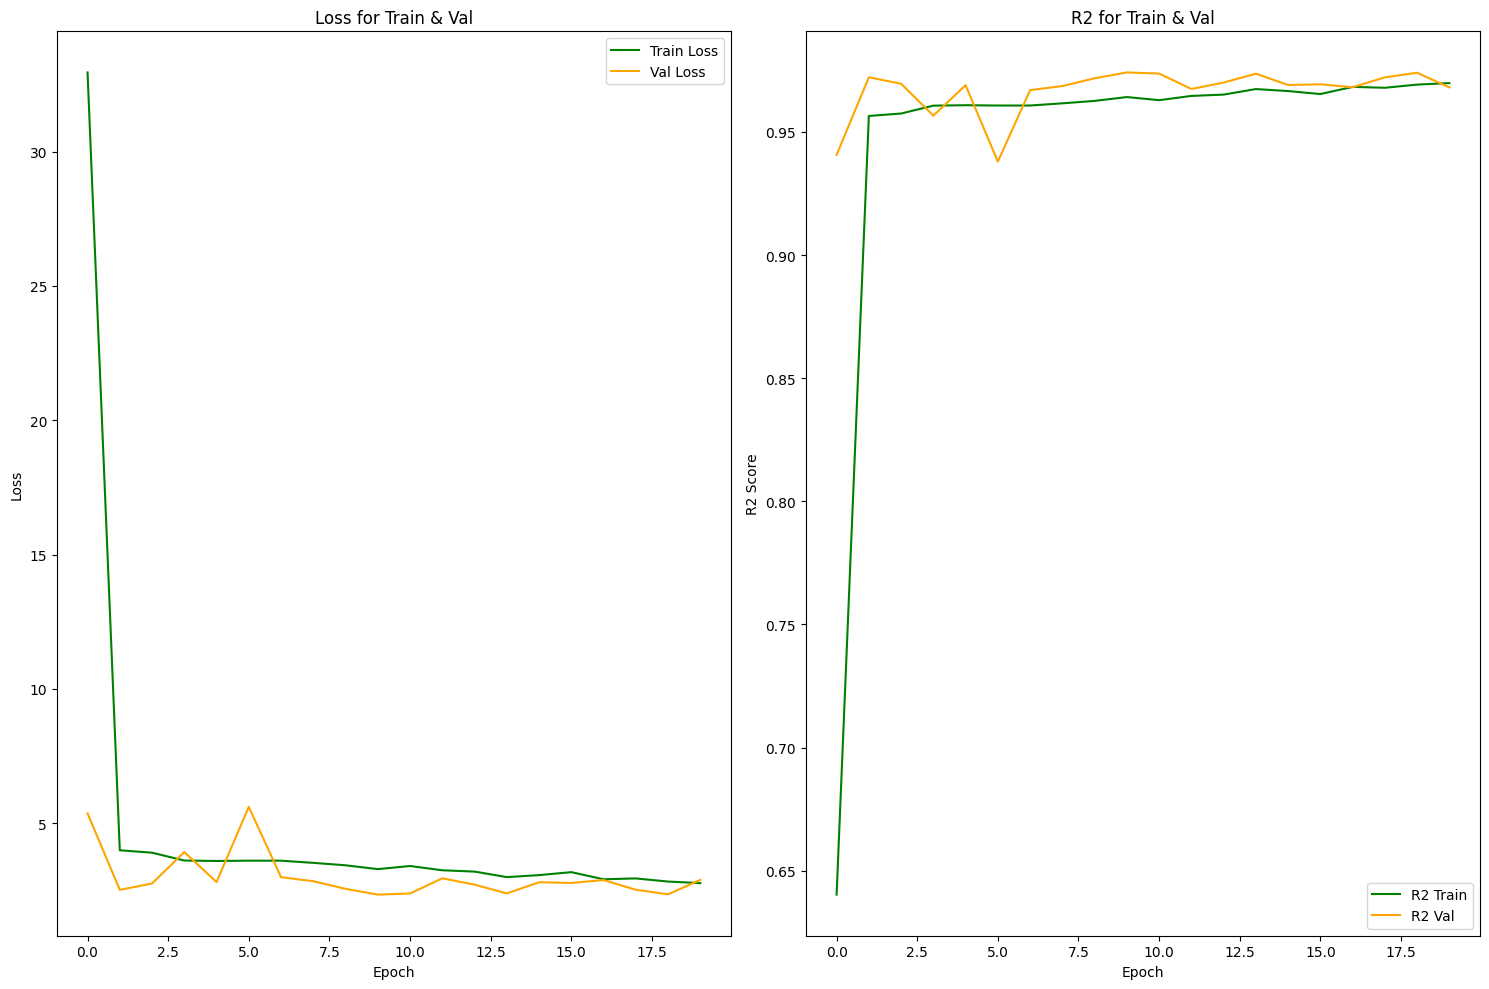

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].plot(train_lossess, color='green', label = 'Train Loss')
ax[0].plot(val_lossess, color='orange', label = 'Val Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss for Train & Val')
ax[0].legend()

ax[1].plot(metric_dict_train_collect["R2 Score"], color='green', label = 'R2 Train')
ax[1].plot(metric_dict_val_collect["R2 Score"], color='orange', label = 'R2 Val')
ax[1].set(xlabel='Epoch', ylabel='R2 Score')
ax[1].set_title('R2 for Train & Val')
ax[1].legend()

plt.tight_layout()

plt.show()

In [47]:
training.test()

Test session - Test Loss: 2.955721074487954 - R2 Score: 0.9672945752152592
